In [37]:
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import seaborn as sns
import numpy as np
import os
import json

from matplotlib import cm
import sympy
import pandas as pd
from sympy import *
import json
import matplotlib.gridspec as gridspec
from celluloid import Camera
import os
from sympy.core.rules import Transform
import itertools
from textwrap import wrap

In [56]:
import scienceplots
plt.style.use(['science', 'notebook', 'scatter'])
#plt.style.use('science')

../../Output/feynman_algos_tracker_no-early-stop_big-steps_niter60/feynman_algos_seed3/random_v18_Sigma0,0_Num4000_seed3_exp(-(((x0-x1)÷x2)**2)÷2,0)÷(2,5*x2)


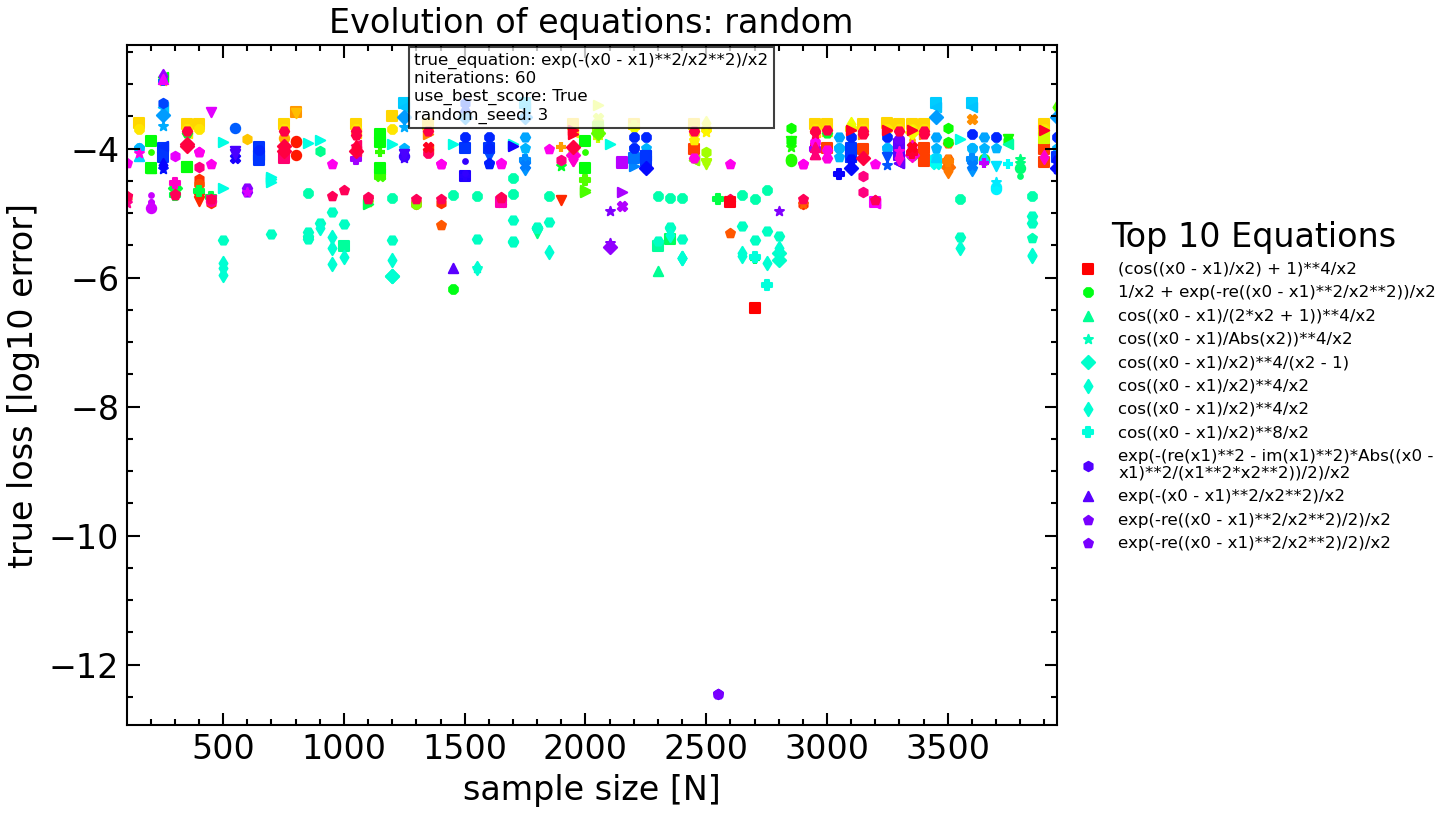

../../Output/feynman_algos_tracker_no-early-stop_big-steps_niter60/feynman_algos_seed3/std_v18_Sigma0,0_Num4000_seed3_exp(-(((x0-x1)÷x2)**2)÷2,0)÷(2,5*x2)


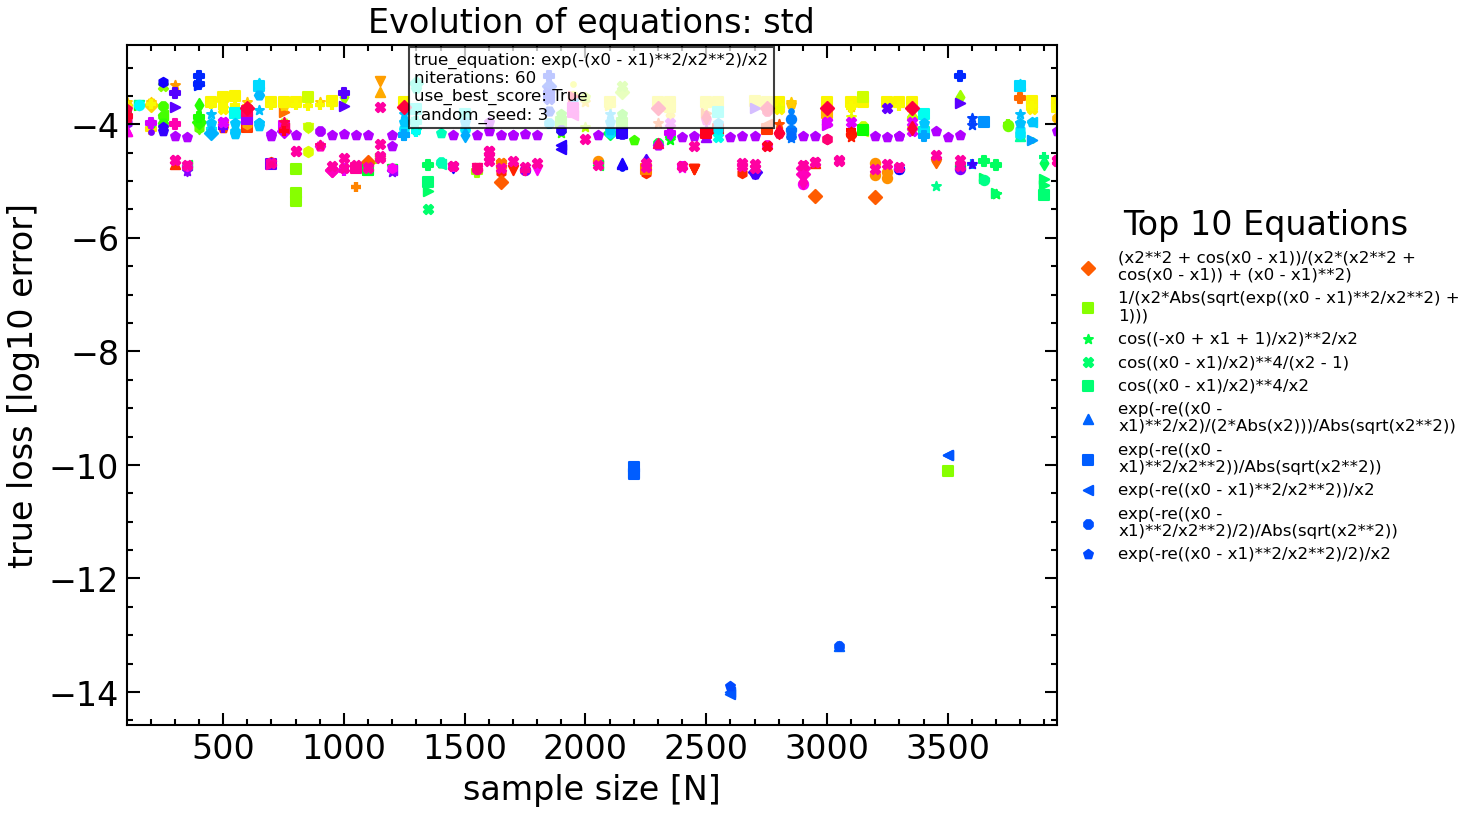

../../Output/feynman_algos_tracker_no-early-stop_big-steps_niter60/feynman_algos_seed3/loss_std_v18_Sigma0,0_Num4000_seed3_exp(-(((x0-x1)÷x2)**2)÷2,0)÷(2,5*x2)


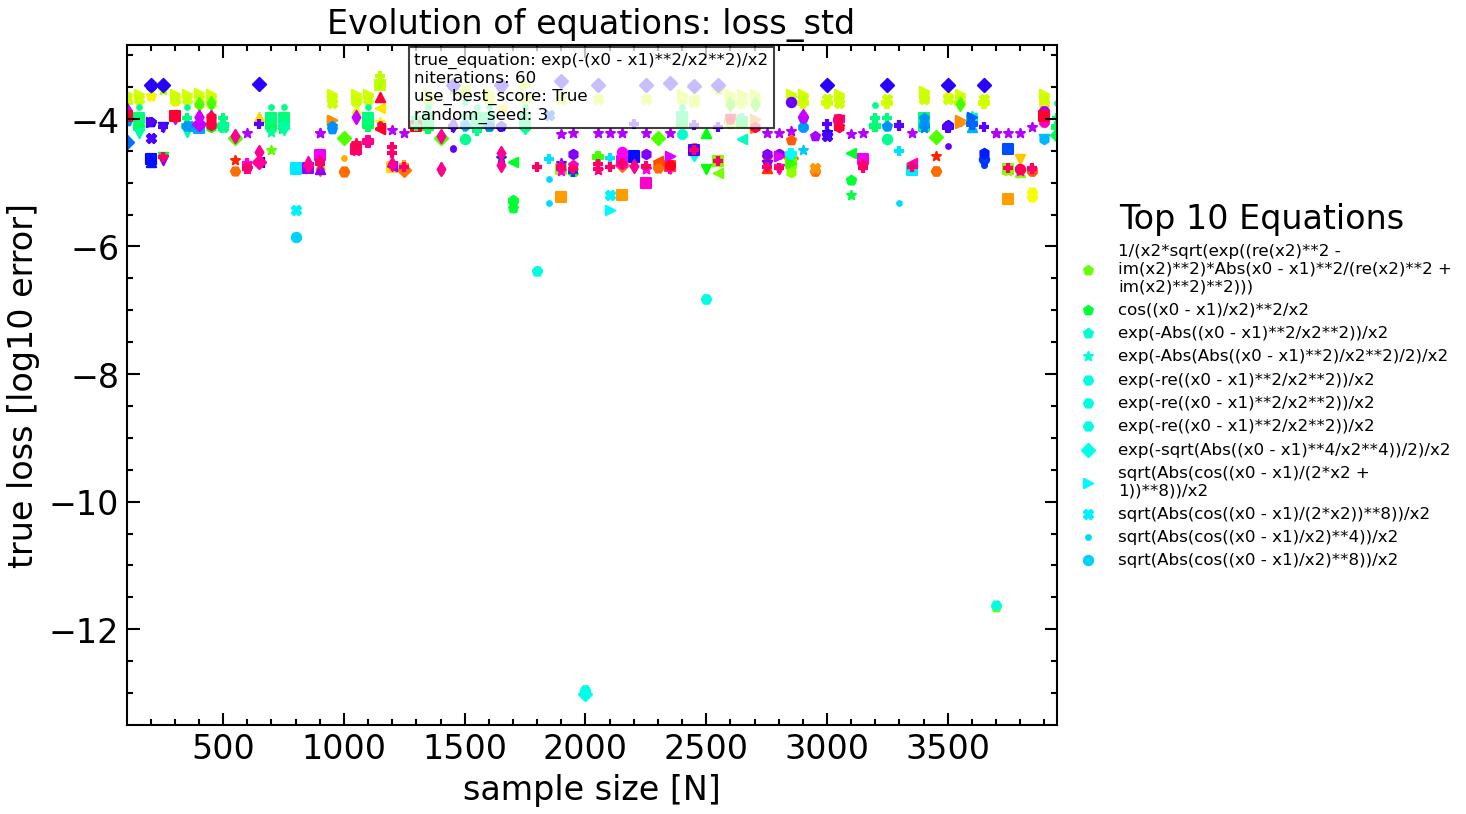

../../Output/feynman_algos_tracker_no-early-stop_big-steps_niter60/feynman_algos_seed3/combinatory_v18_Sigma0,0_Num4000_seed3_exp(-(((x0-x1)÷x2)**2)÷2,0)÷(2,5*x2)


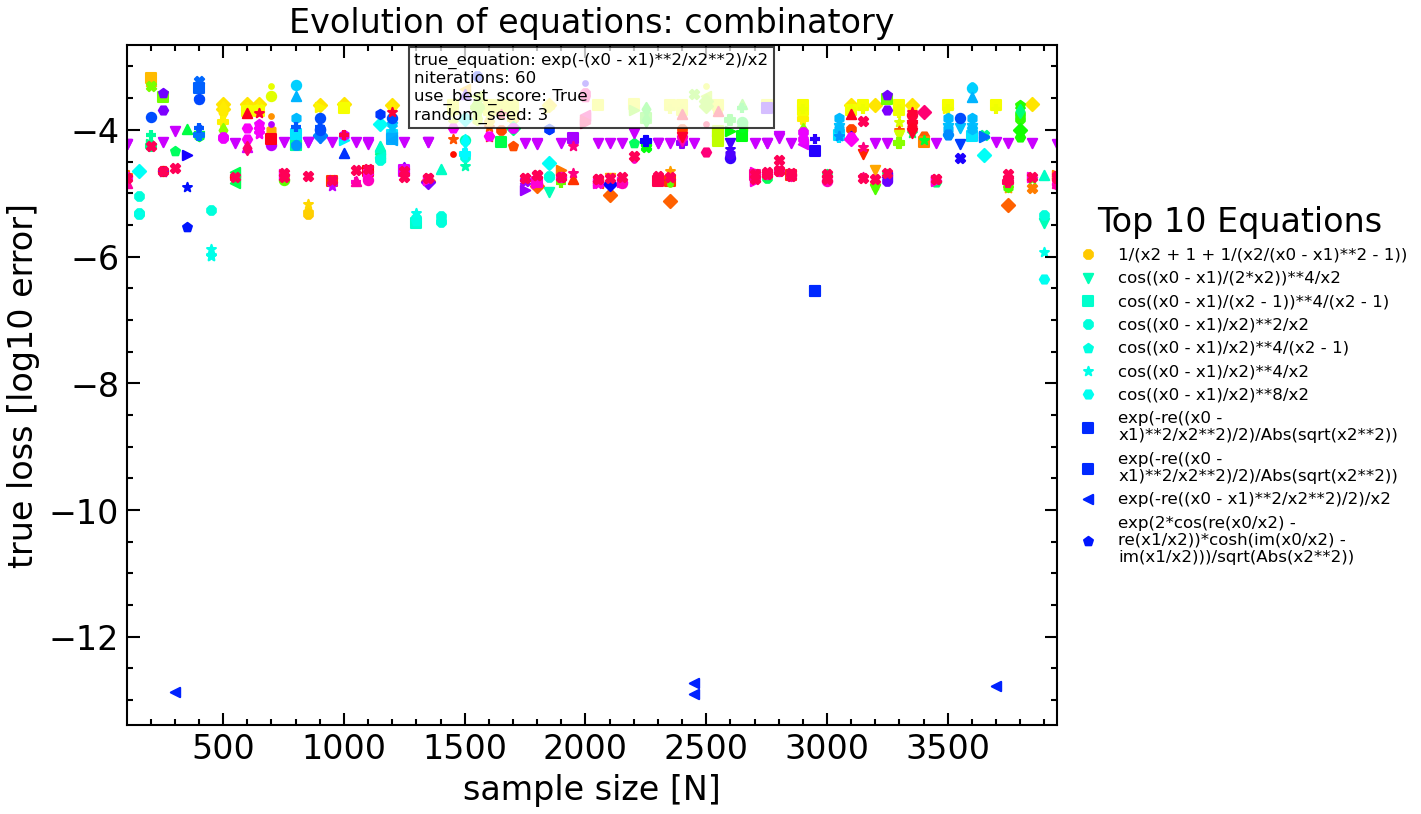

../../Output/feynman_algos_tracker_no-early-stop_big-steps_niter60/feynman_algos_seed3/complexity_std_v18_Sigma0,0_Num4000_seed3_exp(-(((x0-x1)÷x2)**2)÷2,0)÷(2,5*x2)


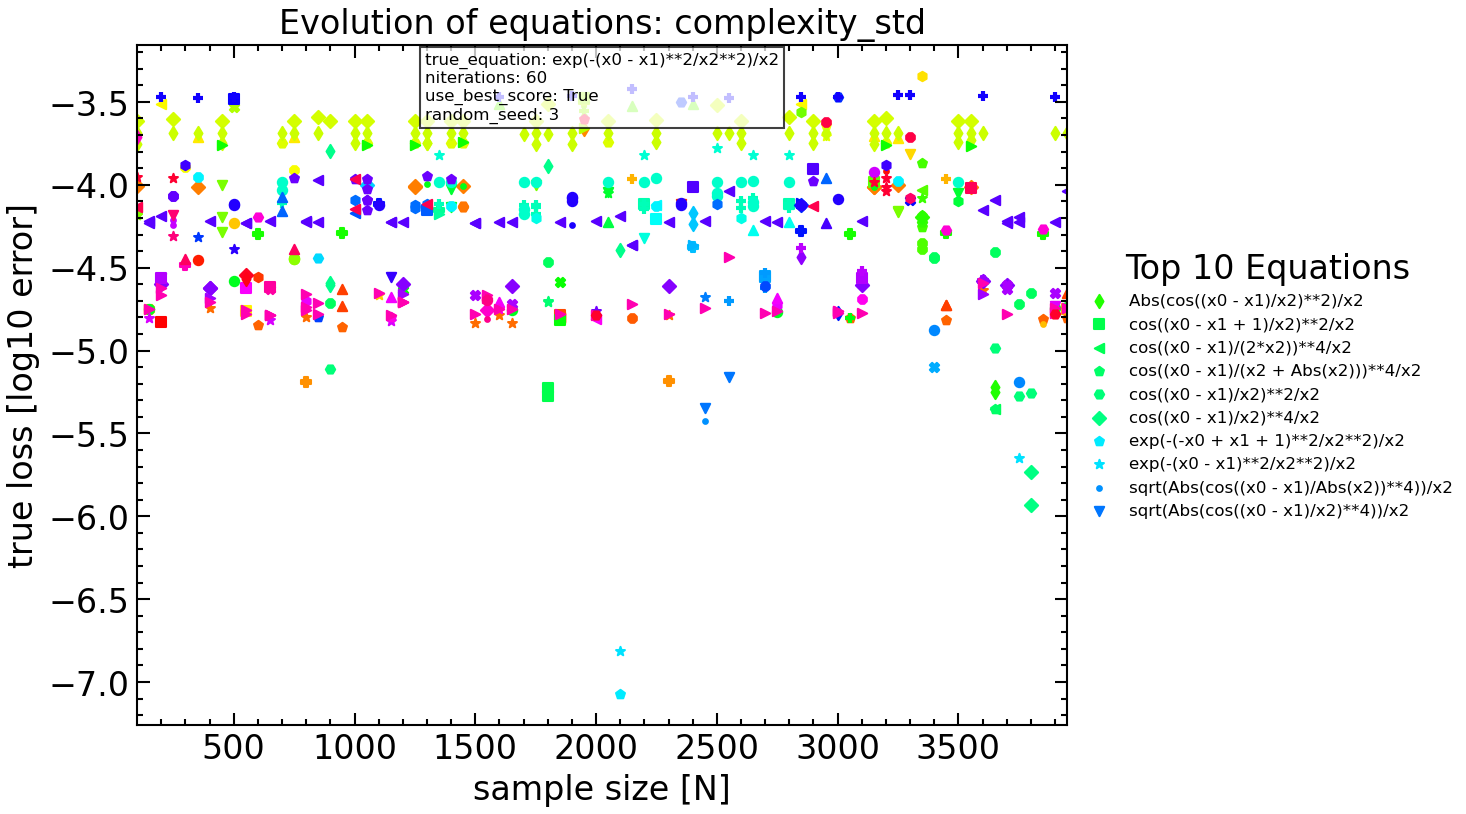

CPU times: user 21.3 s, sys: 6.97 s, total: 28.3 s
Wall time: 32.5 s


In [64]:
%%time
# import data
parentdir = f"../../Output/feynman_algos_tracker_no-early-stop_big-steps_niter60/feynman_algos_seed3/"
subfolders = [ f.path for f in os.scandir(parentdir) if f.is_dir() ]
for folder in subfolders:
    if ".ipynb" in folder:
        subfolders.remove(folder)
        continue

        
def get_cmap_string(palette, domain):
        domain_unique = np.unique(domain)
        hash_table = {key: i_str for i_str, key in enumerate(domain_unique)}
        mpl_cmap = matplotlib.cm.get_cmap(palette, lut=len(domain_unique))

        def cmap_out(X, **kwargs):
            return mpl_cmap(hash_table[X], **kwargs)

        return cmap_out
    
def _read_parameters(dirname):
    with open(f'{dirname}/parameters.json', 'r') as openfile:
        json_object = json.load(openfile)
    return json_object

def _transform_eq(eq):
    try:
        eq = simplify(eq)
    except:
        pass
    if isinstance(eq, (Float, Integer)):
        return None
    eq = eq.xreplace(Transform(lambda x: 1, lambda x: isinstance(x, (Float)) and x>=0))
    eq = eq.xreplace(Transform(lambda x: -1, lambda x: isinstance(x, (Float)) and x<0))
    return eq

for folder in subfolders:
    print(folder)
    parameters = _read_parameters(folder)
    equations = pd.read_csv(f'{folder}/equations.csv')
    loss = pd.read_csv(f'{folder}/loss.csv')
    
    equations = equations.loc[equations.sample_size == equations.sample_size.unique()[-1]].reset_index(drop=True)
    loc_list = list()
    for i in range(len(equations.location)):
        locs = equations.location[i].split(",")
        #del locs[1::2]
        locs_fused = list()
        for k in range(0,len(locs), 2):
            locs_fused.append([int(locs[k][1:]), int(locs[k+1][:-1])])
        #print(locs)
        #print(locs_fused)
        #locs = [x[1:] for x in locs]
        loc_list.append([locs_fused])
    eq_loc_df = pd.concat((equations.equation, pd.DataFrame(loc_list, columns=["location"])), axis=1)
    #print(eq_loc_df)
    df = pd.DataFrame(columns=["sample_size", "equation", "loss"])
    for n in loss.sample_size.unique().tolist():
        for index, eq in eq_loc_df.iterrows():
            indices = [i for i, x in enumerate([x[0] for x in eq.location]) if x == n]
            if indices == []: continue
            for idx in indices:
                #print("n", n)
                #print("eq", eq)
                #print("idx", idx)
                draft_df = pd.DataFrame(columns=["sample_size", "equation", "loss"])
                draft_df["sample_size"] = n
                draft_df["equation"] = eq.equation
                #print("test", loss.loss.loc[loss.sample_size == n].reset_index(drop=True)[eq.location[idx][1]])
                draft_df["loss"] = loss.loss.loc[loss.sample_size == n].reset_index(drop=True)[eq.location[idx][1]]
                new_row = pd.DataFrame({"sample_size": [n], "equation": [eq.equation], "loss": [loss.loss.loc[loss.sample_size == n].reset_index(drop=True)[eq.location[idx][1]]]})
                #print(draft_df)
                df = pd.concat([df,new_row], axis=0)
            
            
    df = df.sort_values("equation").reset_index()
    #print(df.sort_values(by="loss", ascending=True).drop_duplicates(subset=["equation"], keep='first').loss.tolist()[:10])
    
    fig,ax = plt.subplots(1, figsize=(10,6), dpi=150)
    
    marker_list = itertools.cycle((',', '+', '.', 'o', '*', 'v', 'h', '^', 's', '<', '8', 'p', '*', 'H', 'D', 'd', 'P', '>', 'X')) 

    #N = np.unique(df['sample_size'].tolist()).sort()
    plt.xlim([df.sample_size.min(), df.sample_size.max()])
    cmap = get_cmap_string(palette='hsv', domain=equations.sample(frac=1).reset_index(drop=True).equation.tolist())
    marker = next(marker_list)
    prev_eq = None
    for index, row in df.iterrows():
        marker = next(marker_list) if row.equation != prev_eq and index != 0 else marker
        if row.loss in df.sort_values(by="loss", ascending=True).drop_duplicates(subset=["equation"], keep='first').loss.tolist()[:10]:
            #print(row.loss, marker)
            ax.scatter(row.sample_size, np.log10(row.loss), s=20, color=cmap(row.equation), marker=marker, label='\n'.join(wrap(row.equation, 40)))
        else:
            ax.scatter(row.sample_size, np.log10(row.loss), s=20, color=cmap(row.equation), marker=marker)
        prev_eq = row.equation
        
    
    # Shrink current axis by 20%
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

    # Put a legend to the right of the current axis
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), prop={'size': 8}, title="Top 10 Equations")

    # Put a legend below current axis
   
    props = dict(boxstyle='square', facecolor='white', alpha=0.75)

    # place a text box in upper left in axes coords
    textstr = f"""true_equation: {str(_transform_eq(parameters["equation"]))}
niterations: {parameters["niterations"]}
use_best_score: {parameters["use_best_score"]}
random_seed: {parameters["seed"]}"""
    ax.text(0.5, 0.99, textstr, transform=ax.transAxes, fontsize=8,
            verticalalignment='top', ma='left',ha='center', bbox=props)

    plt.xlabel("sample size [N]")
    plt.ylabel("true loss [log10 error]")
    plt.title(f"Evolution of equations: {parameters['algorithm']}")
    plt.draw()
    plt.show()
    filename = f"{parentdir}/{parameters['algorithm']}_eq_evo.png"
    fig.savefig(filename, dpi=150, bbox_inches='tight')

    